In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras import regularizers
from IPython.display import Image

Extract curated dataset

In [2]:
! unzip /content/drive/MyDrive/Combined_Dataset.zip
dataset_dir = "/content/content/AIRecognition"

Streaming output truncated to the last 5000 lines.
  inflating: content/AIRecognition/fake/fake-v2/13943.png  
  inflating: content/AIRecognition/fake/fake-v2/2587.jpg  
  inflating: content/AIRecognition/fake/fake-v2/11963.jpg  
  inflating: content/AIRecognition/fake/fake-v2/20878.png  
  inflating: content/AIRecognition/fake/fake-v2/13839.png  
  inflating: content/AIRecognition/fake/fake-v2/19956.png  
  inflating: content/AIRecognition/fake/fake-v2/22093.png  
  inflating: content/AIRecognition/fake/fake-v2/2704.jpg  
  inflating: content/AIRecognition/fake/fake-v2/16898.png  
  inflating: content/AIRecognition/fake/fake-v2/20703.png  
  inflating: content/AIRecognition/fake/fake-v2/23931.png  
  inflating: content/AIRecognition/fake/fake-v2/17039.png  
  inflating: content/AIRecognition/fake/fake-v2/2647.jpg  
  inflating: content/AIRecognition/fake/fake-v2/24691.png  
  inflating: content/AIRecognition/fake/fake-v2/19245.png  
  inflating: content/AIRecognition/fake/fake-v2/1372

In [4]:
img_height = 224
img_width = 224
batch_size = 100

# Load the training data
train_ds = tf.keras.utils.image_dataset_from_directory(
  dataset_dir,
  validation_split=0.2,
  shuffle=True,
  subset="training",
  seed = 512,
  image_size = (img_height, img_width),
  batch_size = batch_size)

# Load the validation data
val_ds = tf.keras.utils.image_dataset_from_directory(
  dataset_dir,
  validation_split=0.2,
  subset="validation",
  seed = 512,
  image_size = (img_height, img_width),
  batch_size = batch_size)

data_augmentation = tf.keras.Sequential([
    RandomFlip("horizontal_and_vertical"),  # Randomly flip images horizontally and vertically
    RandomRotation(0.2),  # Randomly rotate images by 20%
    RandomZoom(0.2),  # Randomly zoom into images
    RandomContrast(0.2)  # Randomly adjust contrast
])

augmented_train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))

class_names = train_ds.class_names

Found 27548 files belonging to 2 classes.
Using 22039 files for training.
Found 27548 files belonging to 2 classes.
Using 5509 files for validation.


In [5]:
VGG_base_model = tf.keras.applications.VGG16(
    include_top = False,
    weights = 'imagenet',
    input_shape = (img_height, img_width, 3)
)
VGG_base_model.trainable = True

# Create a new model on top of the VGG-16 base model
inputs = tf.keras.Input(shape = (img_height, img_width, 3))
x = VGG_base_model(inputs, training = False)
x = GlobalAveragePooling2D()(x)
outputs = Dense(1, activation = 'sigmoid')(x)
VGG_model = tf.keras.Model(inputs, outputs)

# Compile the model
VGG_model.compile(
    optimizer = tf.keras.optimizers.Adamax(learning_rate = 0.001),
    loss = tf.keras.losses.BinaryCrossentropy(),
    metrics = ['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

VGG_model.summary()

58889256/58889256 [==============================] - 3s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d (  (None, 512)               0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 1)                 513       
                                                                 
Total params: 14715201 (56.13 MB)
Trainable params: 14715201 (56.13 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [6]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 10, restore_best_weights = True)

VGG_model_history = VGG_model.fit(
    augmented_train_ds,
    validation_data = val_ds,
    epochs = 100,
    verbose = 1,
    callbacks = [early_stopping]
)
VGG_model.save('VGG_base_model')

Epoch 1/100
221/221 [==============================] - 423s 2s/step - loss: 4.0966 - accuracy: 0.6312 - precision: 0.3718 - recall: 0.0690 - val_loss: 0.6142 - val_accuracy: 0.6462 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/100
221/221 [==============================] - 339s 2s/step - loss: 0.6184 - accuracy: 0.6518 - precision: 0.6792 - recall: 0.0210 - val_loss: 0.6066 - val_accuracy: 0.6498 - val_precision: 0.8571 - val_recall: 0.0123
Epoch 3/100
221/221 [==============================] - 339s 2s/step - loss: 0.6117 - accuracy: 0.6512 - precision: 0.5684 - recall: 0.0385 - val_loss: 0.5948 - val_accuracy: 0.6462 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/100
221/221 [==============================] - 339s 2s/step - loss: 0.5973 - accuracy: 0.6572 - precision: 0.7065 - recall: 0.0450 - val_loss: 0.5916 - val_accuracy: 0.6526 - val_precision: 0.8571 - val_recall: 0.0215
Epoch 5/100
221/221 [==============================] - 339s 2s/step - loss: 0.55

In [7]:
val_loss, val_accuracy, val_precision, val_recall = VGG_model.evaluate(val_ds)

# Print the metrics
print(f"Val Loss: {val_loss:.4f}")
print(f"Val Accuracy: {val_accuracy:.4f}")
print(f"Val Precision: {val_precision:.4f}")
print(f"Val Recall: {val_recall:.4f}")

56/56 [==============================] - 38s 585ms/step - loss: 0.1742 - accuracy: 0.9414 - precision: 0.9270 - recall: 0.9056
Val Loss: 0.1742
Val Accuracy: 0.9414
Val Precision: 0.9270
Val Recall: 0.9056


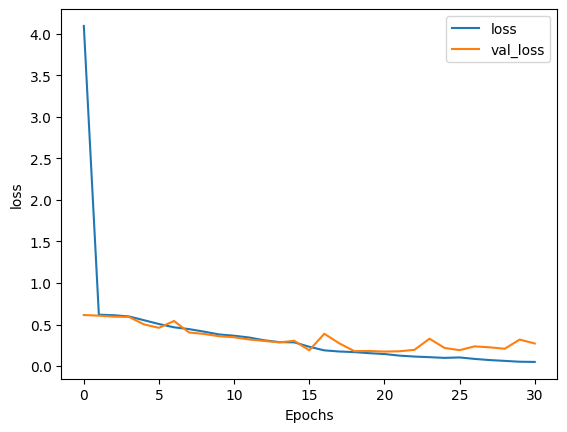

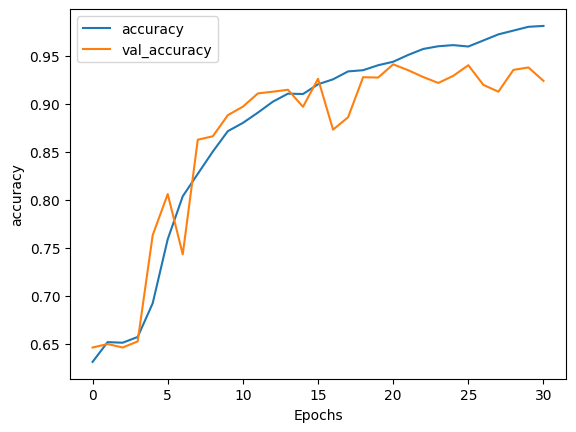

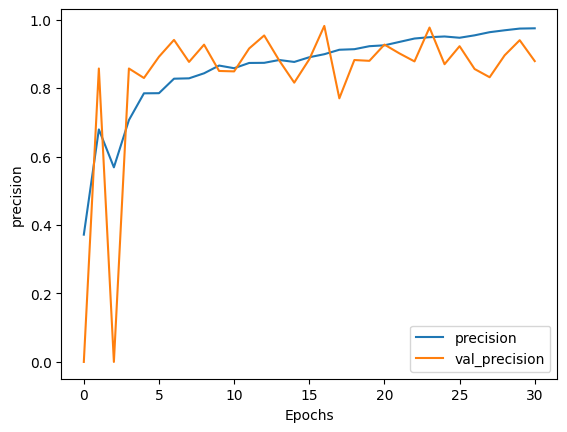

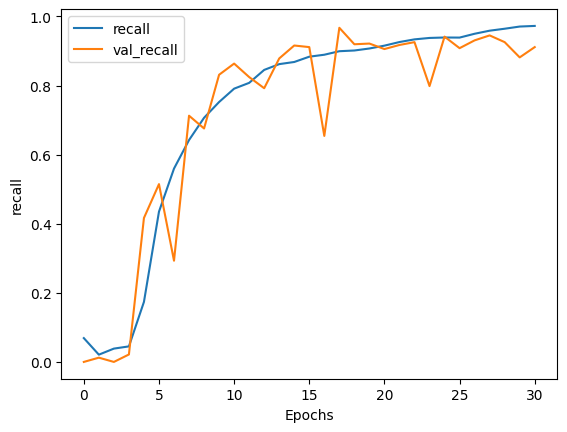

In [11]:
def plot_metrics(history, metric):
    plt.plot(history.history[metric], label = metric)
    plt.plot(history.history['val_' + metric], label='val_' + metric)
    plt.xlabel('Epochs')
    plt.ylabel(metric)
    plt.legend()
    plt.show()

plot_metrics(VGG_model_history, 'loss')
plot_metrics(VGG_model_history, 'accuracy')